In [1]:
from IPython.display import Image
from pathlib import Path

path_data = Path.cwd() / 'data'

# Guide to Pyqgis
There are common elements in a QGIS project that are accessed in scripts, so it is best to set these items up automatically and consistently

Load the current project in the `QgsProject` class

```
project = QgsProject.instance()
```

Within a project, data is divided into layers that are related to each other in a tree structure, like the following image:

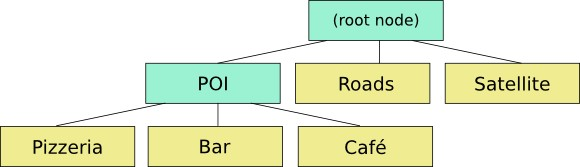

In [2]:
# image source: https://www.lutraconsulting.co.uk/blog/2014/07/06/qgis-layer-tree-api-part-1/
display(Image(path_data / 'qgis_layer_tree_structure.jpg', width=400))

The figure shows a tree, and every element (box) is a node. The tree structure starts with the root node or top folder, in the `QgsLayerTree` class:

```
root = project.layerTreeRoot()
```

If a node has node(s) within it (connect by a line below it), it is called a group node (green boxes) and is in the `QgsLayerTreeGroup` class. If there are no node(s) within it, it is called a layer node (yellow boxes) and is in the `QgsLayerTreeLayer` class. Nodes within a group are called children (the group node is the parent). If a node has children, `.children()` returns all the direct children as a list:

```
root.children()
```

Children can be accessed by their positions in the list:

```
child0 = root.children()[0]
```

#### Working with groups

To see *ALL* groups within a node, returns list of `QgsTreeLayerGroup' objects (add argument True to see all subgroups):

```
groups = root.findGroups()
# convert objects to their names
group_names = [group.name() for group in groups]
```

To find a group by its name, use:

```
root.findGroup('Group Name')
```

Add a group to any part of tree

```
group = root.addGroup('Group Name')
```

Check if node is group, returns boolean value:

```
child0 = root.children()[0]
isinstance(child0, QgsLayerTreeGroup)
```

#### Working with layers

To see *ALL* layers within a project, the following returns all layers as a list:

```
layers = root.findLayers()
```

...or the following returns all layers as a dictionary, where keys equal the layer's unique id, and the values contains information about the layer

```
layers = project.mapLayers()
```

Find a layer using the name:

```
country_layer = project.mapLayersByName('countries')[0]
````

Find a layer using the layer's id:

```
root.findLayer(layer.id())
```

Check if node is layer, returns boolean value:

```
child0 = root.children()[0]
isinstance(child0, QgsLayerTreeLayer)
```

Set layer visibilty on map (True to check checkbox, False unchecks checkbox):

```
root.findLayer(layer.id()).setItemVisibilityChecked(Bool)
```

Moving an existing node is done in three steps:
1. cloning the existing node
2. moving the cloned node to the desired position
3. deleting the original node

```
# clone the group
cloned_group1 = node_group1.clone()

# move the node (along with sub-groups and layers) to the top
root.insertChildNode(0, cloned_group1)

# remove the original node
root.removeChildNode(node_group1)
```

It is a little bit more complicated, but can also move a layer around in the legend or to an existing group (see https://docs.qgis.org/3.28/en/docs/pyqgis_developer_cookbook/legend.html)

* [ ] https://www.lutraconsulting.co.uk/blog/2014/07/25/qgis-layer-tree-api-part-2/
* [ ] https://www.lutraconsulting.co.uk/blog/2015/01/30/qgis-layer-tree-api-part-3/
* [ ] https://docs.qgis.org/3.28/en/docs/pyqgis_developer_cookbook/raster.html
* [ ] https://opensourceoptions.com/qgis-python-tutorial-pyqgis-tutorial/#:~:text=QGIS%20Python%20Tutorial%20%28PyQGIS%20Tutorial%29%201%20QGIS%20Python,Can%20Do%20with%20PyQGIS%20...%208%20Conclusion%20 >> Get Layer Fields and File Path

## Vector layers

Vector layers are stored in `QgsVectorLayer` class

Switch from `QgsLayerTreeLayer` to `QgsVectorLayer`, use `.layer()`:

```
layers[0].layer()
```

Add vector by creating vector layer, and adding it through the `QgsProject` object:

```
# create QgsVectorLayer object 
layer = QgsVectorLayer('path_to_layer', 'Layer', 'ogr')

# if layer is valid, load it into QgsProject, then insert it into desired position in TOC
if not layer.isValid():
    print("Layer failed to load!")
else:
    # False makes sure layer does not show in legend
    project.addMapLayer(layer, False)

    # control position of added layer (negative numbers add from bottom up)
    root.insertLayer(0, layer) 
```

*.addLayer(layer) always appends the layer to the end of the group, .insertLayer() gives more control*


...or add vector layer to project in one step using the `QgisInterface` class:

```
vlayer = iface.addVectorLayer('testdata/airports.shp', 'Airports layer', 'ogr')
if not vlayer:
  print('Layer failed to load!')
```

Check fields in layer to make sure it loaded correctly:

```
[f'{field.name()}:{field.typeName()}' for field in layer.fields()]
```

Export vector layer (CAUTION if file already exists, it is overwritten):

```
QgsVectorFileWriter.writeAsVectorFormat(layer, str_path, 'Shift-JIS', QgsCoordinateReferenceSystem(4612), 'ESRI Shapefile')
```

When a vector layer is being rendered, the appearance of the data is given by renderer and symbols associated with the layer. Symbols are classes which take care of drawing of visual representation of features, while renderers determine what symbol will be used for a particular feature.

Delete layer from project only, not the actual file:

```
project.removeMapLayer(layer.id())
```

#### CSV or delimited text files
To open a file with a semicolon as a delimiter, with field "x" for X coordinate and field "y" for Y coordinate you would use something like this:

```
uri = "file://{}/testdata/delimited_xy.csv?delimiter={}&xField={}&yField={}".format(os.getcwd(), ";", "x", "y")
vlayer = QgsVectorLayer(uri, "layer name you like", "delimitedtext")
QgsProject.instance().addMapLayer(vlayer)
```

* [ ] Improving Performance for ESRI Shapefile format datasets

To improve the drawing performance for an ESRI Shapefile format dataset, you can create a spatial index. A spatial index will improve the speed of both zooming and panning. Spatial indexes used by QGIS have a .qix extension.

Use these steps to create the index:

    Load an ESRI Shapefile format dataset (see The Browser Panel)

    Open the Layer Properties dialog by double-clicking on the layer name in the legend or by right-clicking and choosing Properties… from the context menu

    In the Source tab, click the Create Spatial Index button


## Raster layers

Raster layers are stored  in `QgsRasterLayer` class

Similarly to vector layers, raster layers can be loaded using the addRasterLayer function of the `QgisInterface` object:
    
```
iface.addRasterLayer(path_to_tif, "layer name you like")
```

#### References

* PYGIS docs: https://qgis.org/pyqgis/3.28/index.html
* https://docs.qgis.org/3.28/en/docs/pyqgis_developer_cookbook/index.html
* https://opensourceoptions.com/pyqgis-calculate-geometry-and-field-values-with-the-qgis-python-api/ >> use field calculator
* https://docs.qgis.org/3.28/en/docs/user_manual/processing/console.html#processing-console >> run algorithms

Get details about and manipulate the project

```
# get absolute path of project file
project.fileName()
```

Can perform actions on project

```
# load another project
project.read(r'path\project.qgz')

# save project
project.write()
* pass absolute path arg to save in new location and as new project name
```

Save project file:

```
project.write()
```

Contents from .md file

Python's `pyqgis` Library Guide

This document provides a guide to using the `pyqgis` library in Python. 

## 



- 

### 

```python
from IPython.display import Image
from pathlib import Path
path_data = Path.cwd() / 'data'
# image source: https://www.lutraconsulting.co.uk/blog/2014/07/06/qgis-layer-tree-api-part-1/
display(Image(path_data / 'qgis_layer_tree_structure.jpg', width=400))
```

The figure shows a tree, and every element (box) is a node. The tree structure starts with the `root` node or top folder, in the `QgsLayerTree` class:

```python
>>> project = QgsProject.instance()
>>> root = project.layerTreeRoot()
>>> root.children()
```

A node with node(s) within it (connected by a line below it) is called a group node (green boxes). All? group nodes are in the `QgsLayerTreeGroup` class. The node(s) within a group node are called children (while the group node is called the parent). If a node has children, `.children()` returns all the direct children as a list:


A node without nodes within it is called a layer node (yellow boxes). All? layer nodes are in the `QgsLayerTreeLayer` class. 

### Accessing Children

- Children can be accessed by their positions in the list

```python
child_0 = root.children()[0]
```

**Example:**
```python
>>> if not Path().exists():
>>>     print("File doesn't exist")
"File doesn't exist" # printed because the files does not exist
```

### Create Directory

- Creates a directory **only if it does not already exist**.

```python
>>> Path().mkdir()
```

**Args:**
- `exist_ok`: default=`False`. If the directory exists, raises `FileExistsError`. `True` ignores `FileExistsError`, and does not overwrite the directory.


#### Working with groups

To see *ALL* groups within a node, returns list of `QgsTreeLayerGroup' objects (add argument True to see all subgroups):

```
groups = root.findGroups()
# convert objects to their names
group_names = [group.name() for group in groups]
```

To find a group by its name, use:

```
root.findGroup('Group Name')
```

Add a group to any part of tree

```
group = root.addGroup('Group Name')
```

Check if node is group, returns boolean value:

```
child0 = root.children()[0]
isinstance(child0, QgsLayerTreeGroup)
```

#### Working with layers

To see *ALL* layers within a project, the following returns all layers as a list:

```
layers = root.findLayers()
```

...or the following returns all layers as a dictionary, where keys equal the layer's unique id, and the values contains information about the layer

```
layers = project.mapLayers()
```

Find a layer using the name:

```
country_layer = project.mapLayersByName('countries')[0]
````

Find a layer using the layer's id:

```
root.findLayer(layer.id())
```

Check if node is layer, returns boolean value:

```
child0 = root.children()[0]
isinstance(child0, QgsLayerTreeLayer)
```

Set layer visibilty on map (True to check checkbox, False unchecks checkbox):

```
root.findLayer(layer.id()).setItemVisibilityChecked(Bool)
```

Moving an existing node is done in three steps:
1. cloning the existing node
2. moving the cloned node to the desired position
3. deleting the original node

```
# clone the group
cloned_group1 = node_group1.clone()

# move the node (along with sub-groups and layers) to the top
root.insertChildNode(0, cloned_group1)

# remove the original node
root.removeChildNode(node_group1)
```

It is a little bit more complicated, but can also move a layer around in the legend or to an existing group (see https://docs.qgis.org/3.28/en/docs/pyqgis_developer_cookbook/legend.html)

* [ ] https://www.lutraconsulting.co.uk/blog/2014/07/25/qgis-layer-tree-api-part-2/
* [ ] https://www.lutraconsulting.co.uk/blog/2015/01/30/qgis-layer-tree-api-part-3/
* [ ] https://docs.qgis.org/3.28/en/docs/pyqgis_developer_cookbook/raster.html
* [ ] https://opensourceoptions.com/qgis-python-tutorial-pyqgis-tutorial/#:~:text=QGIS%20Python%20Tutorial%20%28PyQGIS%20Tutorial%29%201%20QGIS%20Python,Can%20Do%20with%20PyQGIS%20...%208%20Conclusion%20 >> Get Layer Fields and File Path


## Vector layers

Vector layers are stored in `QgsVectorLayer` class

Switch from `QgsLayerTreeLayer` to `QgsVectorLayer`, use `.layer()`:

```
layers[0].layer()
```

Add vector by creating vector layer, and adding it through the `QgsProject` object:

```
# create QgsVectorLayer object 
layer = QgsVectorLayer('path_to_layer', 'Layer', 'ogr')

# if layer is valid, load it into QgsProject, then insert it into desired position in TOC
if not layer.isValid():
    print("Layer failed to load!")
else:
    # False makes sure layer does not show in legend
    project.addMapLayer(layer, False)

    # control position of added layer (negative numbers add from bottom up)
    root.insertLayer(0, layer) 
```

*.addLayer(layer) always appends the layer to the end of the group, .insertLayer() gives more control*


...or add vector layer to project in one step using the `QgisInterface` class:

```
vlayer = iface.addVectorLayer('testdata/airports.shp', 'Airports layer', 'ogr')
if not vlayer:
  print('Layer failed to load!')
```

Check fields in layer to make sure it loaded correctly:

```
[f'{field.name()}:{field.typeName()}' for field in layer.fields()]
```

Export vector layer (CAUTION if file already exists, it is overwritten):

```
QgsVectorFileWriter.writeAsVectorFormat(layer, str_path, 'Shift-JIS', QgsCoordinateReferenceSystem(4612), 'ESRI Shapefile')
```

When a vector layer is being rendered, the appearance of the data is given by renderer and symbols associated with the layer. Symbols are classes which take care of drawing of visual representation of features, while renderers determine what symbol will be used for a particular feature.

Delete layer from project only, not the actual file:

```
project.removeMapLayer(layer.id())
```

#### CSV or delimited text files
To open a file with a semicolon as a delimiter, with field "x" for X coordinate and field "y" for Y coordinate you would use something like this:

```
uri = "file://{}/testdata/delimited_xy.csv?delimiter={}&xField={}&yField={}".format(os.getcwd(), ";", "x", "y")
vlayer = QgsVectorLayer(uri, "layer name you like", "delimitedtext")
QgsProject.instance().addMapLayer(vlayer)
```

* [ ] Improving Performance for ESRI Shapefile format datasets

To improve the drawing performance for an ESRI Shapefile format dataset, you can create a spatial index. A spatial index will improve the speed of both zooming and panning. Spatial indexes used by QGIS have a .qix extension.

Use these steps to create the index:

    Load an ESRI Shapefile format dataset (see The Browser Panel)

    Open the Layer Properties dialog by double-clicking on the layer name in the legend or by right-clicking and choosing Properties… from the context menu

    In the Source tab, click the Create Spatial Index button


## Raster layers

Raster layers are stored  in `QgsRasterLayer` class

Similarly to vector layers, raster layers can be loaded using the addRasterLayer function of the `QgisInterface` object:
    
```
iface.addRasterLayer(path_to_tif, "layer name you like")
```

Get details about and manipulate the project

```
# get absolute path of project file
project.fileName()
```

Can perform actions on project

```
# load another project
project.read(r'path\project.qgz')

# save project
project.write()
* pass absolute path arg to save in new location and as new project name
```


Save project file:

```
project.write()
```


## References

* [Official PYGIS docs v3.28](https://qgis.org/pyqgis/3.28/index.html) >> no longer available online, but can be downloaded
* [Official PyQGIS Developer Cookbook v3.28](https://docs.qgis.org/3.28/en/docs/pyqgis_developer_cookbook/index.html)
* [PyQGIS: Calculate Geometry and Field Values with the QGIS Python API](https://opensourceoptions.com/pyqgis-calculate-geometry-and-field-values-with-the-qgis-python-api/) >> use field calculator
* [Using processing algorithms from the console](https://docs.qgis.org/3.28/en/docs/user_manual/processing/console.html#processing-console) >> run algorithms